In [1]:
from matplotlib import pyplot as plt
from astropy import constants as const
from lmfit.models import VoigtModel, ConstantModel
from scipy.stats import norm
from lmfit import Model
from astropy import log
from astropy.io import fits
import csaps
import pandas as pd
import os
from glob import glob
from os.path import join as opj
from loadspec import *
from absorber_utils_v4_Copy1 import *
import kevlib as kl
%run $kl.common_import_script

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib notebook

print("finished!")

finished!


In [2]:
def voight(lambda0, gamma, f, N, b, vel, Cf, wv):
    z = vel2shift(vel)
    wv_r = wv / (1.0 + z)
    flux = (1.0 - Cf) + Cf * np.exp( -voigt_tau(lambda0, gamma, f, 10**N, b, wv_r) )
    return flux

def voigt_passthough(x, lambda0, gamma, f, N, b, vel, Cf): #x = independent variable/the spectra array?
    return voigt(lambda0, gamma, f, N, b, vel, Cf, wv=x)

from rbvfit import rb_setline as rb
line_cent = 1215
s = rb.rb_setline(line_cent, method = 'closest')
print(s)

model = Model(voigt_passthough)
params = model.make_params()
params

{'wave': 1215.3394, 'fval': 0.4165, 'name': 'DI 1215', 'gamma': 627000000.0}


name,value,initial value,min,max,vary
lambda0,-inf,None,-inf,inf,True
gamma,-inf,None,-inf,inf,True
f,-inf,None,-inf,inf,True
N,-inf,None,-inf,inf,True
b,-inf,None,-inf,inf,True
vel,-inf,None,-inf,inf,True
Cf,-inf,None,-inf,inf,True


In [3]:
catalog = np.loadtxt("./data/absorption_line_check.txt")
plate = catalog[:,0]
fiber = catalog[:,1]
mjd = catalog[:,2]
zqso = catalog[:,3]
zabs = catalog[:,4]

del catalog
index = (1 + zqso) * (1215.16 - 15) > 4000
mjd = mjd[index]
plate = plate[index]
fiber = fiber[index]
zqso = zqso[index]
print('Catalog length =', len(zqso))

Catalog length = 20823


In [4]:
def insert_absorption_line(i, plots = False): #flux not normalized
    
    #randomizing parameters
    column_density = np.random.uniform(19.9, 20.5)
    noise = np.random.uniform(4, 6)
    
    #find redshift, wavelength, and flux
    wl, flux, ferr, ra, dec= kl.io.sdss.load_sdss_spectrum(
        plate = int(plate[i]),
        mjd = int(mjd[i]),
        fiber = int(fiber[i]),
    )
    redshift = zqso[i]
    wavelength, flux, ferr = wl.value, flux.value, ferr.value

    #set up voigt profile
    hydrogen_wavelength = 1215 
    params['b'].set(vary = True, value = 80.000001, min = 0.0, max = 300.0)
    params['lambda0'].set(vary = False, value = hydrogen_wavelength)
    params['gamma'].set(vary = False, value = 6.27 * (10**7.5))
    params['f'].set(vary = False, value = 0.4165)
    params['vel'].set(vary = True, value = 0) #offset redshift
    params['Cf'].set(vary = False, value = 1) #continuum
    params['N'].set(vary = True, value = column_density) #column density log[cm^-2]
    absorption_flux = model.eval(params, x = wavelength / (redshift + 1))

    #insert absorption line
    f = np.multiply(flux, absorption_flux)
    #fix wavelength per redshift
    wavelength = wavelength / (redshift + 1)
    
    #slice wavelength array to inject absorption line
    cut = (wavelength > hydrogen_wavelength - 10) & (wavelength < hydrogen_wavelength + 10)
    flux1 = np.array(f)
    flux_crop = flux1[cut]
    wavelength_crop = wavelength[cut]
    
    #add noise to absorption line
    signal = np.mean(flux_crop)
    noise_sigma = signal / noise
    n = np.random.randn(len(wavelength_crop)) * noise_sigma
    line = flux_crop + n
    f[cut] = line
    
    from kevlib.utils.base_defs import robust_fit

    c = (wavelength > 1180) & (wavelength < 1240)
    cwavelength = wavelength[c]
    
    #fit continuum for FALSE (1180 - 1240 A)
    f_flux = flux[c]
    
    __, f_continuum, __ = robust_fit(
    cwavelength, f_flux,
    ubm = 3,
    sdms = np.linspace(15, 0.8, 20), 
    smooth_strength = 0.7, 
    pdeg = 4, 
    fit_type = 'ss',
    plot_q = False,
)
    f_flux = f_flux / f_continuum
    
    #fit continuum for POSITIVE (1180 - 1240 A)
    cflux = f[c]
    
    __, flux_continuum, __ = robust_fit(
    cwavelength, cflux,
    ubm = 3,
    sdms = np.linspace(15, 0.8, 20), 
    smooth_strength = 0.7, 
    pdeg = 4, 
    fit_type = 'ss',
    plot_q = False,
)
    final_flux = cflux / flux_continuum
    
    if plots:
        fig, (ax1, ax2) = plt.subplots(2)
        ax1.set_title("FALSE sample")
        ax1.plot(wavelength, flux, color = "black", linewidth = 0.5)
        ax1.plot(cwavelength, f_continuum, color = "pink")
        ax1.set_xlim(1180, 1240)
        ax2.plot(cwavelength, f_flux, color = "black", linewidth = 0.5)
        ax2.axhline(1, color = "pink")
        
        fig, (ax1, ax2) = plt.subplots(2)
        ax1.plot(wavelength, flux / np.max(flux), color = "black", linewidth = 0.5)
        ax1.set_xlim(1100, 1350)
        ax2.plot(wavelength, f / np.max(f), color = "black", linewidth = 0.5)
        ax2.set_xlim(1100, 1350)
        
        fig, (ax1, ax2) = plt.subplots(2)
        ax1.set_title("absorption line inserted; noise: " + str(noise))
        ax1.plot(wavelength, absorption_flux, color = "black", linewidth = 0.45, label = "Column Density: " + str(column_density))
        ax1.legend()
        ax1.set_xlim(1175, 1275)
        
        ax2.plot(wavelength_crop, line, color = "black", linewidth = 0.45, label = "cropped + noise added")
        ax2.legend()
        ax2.axvline(x = hydrogen_wavelength, color = "pink")
        ax2.axvline(x = hydrogen_wavelength - 10, color = "purple", linestyle = "dashed")
        ax2.axvline(x = hydrogen_wavelength + 10, color = "purple", linestyle = "dashed")
        
        fig, (ax1, ax2, ax3) = plt.subplots(3)
        ax1.set_title("Normalized w/ Continuum (final); redshift: " + str(redshift))
        ax1.set_xlim(1180, 1240)
        ax1.plot(wavelength, flux, color = "black", linewidth = 0.45, label = "raw flux; redshifted")
        ax1.legend()
        ax2.plot(cwavelength, cflux, color = "black", linewidth = 0.45, alpha = 0.75)
        ax2.plot(cwavelength, flux_continuum, color = "purple", linewidth = 0.5)
        ax3.plot(cwavelength, final_flux, color = "black", linewidth = 0.45, alpha = 0.75)
        ax3.axhline(1, color = "purple", linewidth = 0.5)
        ax3.axvline(hydrogen_wavelength, color = "pink", linewidth = 0.5)
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux")
    
    return final_flux, f_flux #final_flux --> POS, f_flux --> NEG

/media/rd1/kwillis/kevlib_dev/src/kevlib/io/sdss.py:153: RuntimeWarning: divide by zero encountered in power
  ferr = hdul[1].data[fiber - 1, :]**(-0.5) * sdss_flux_unit # To standard deviation


<IPython.core.display.Javascript object>


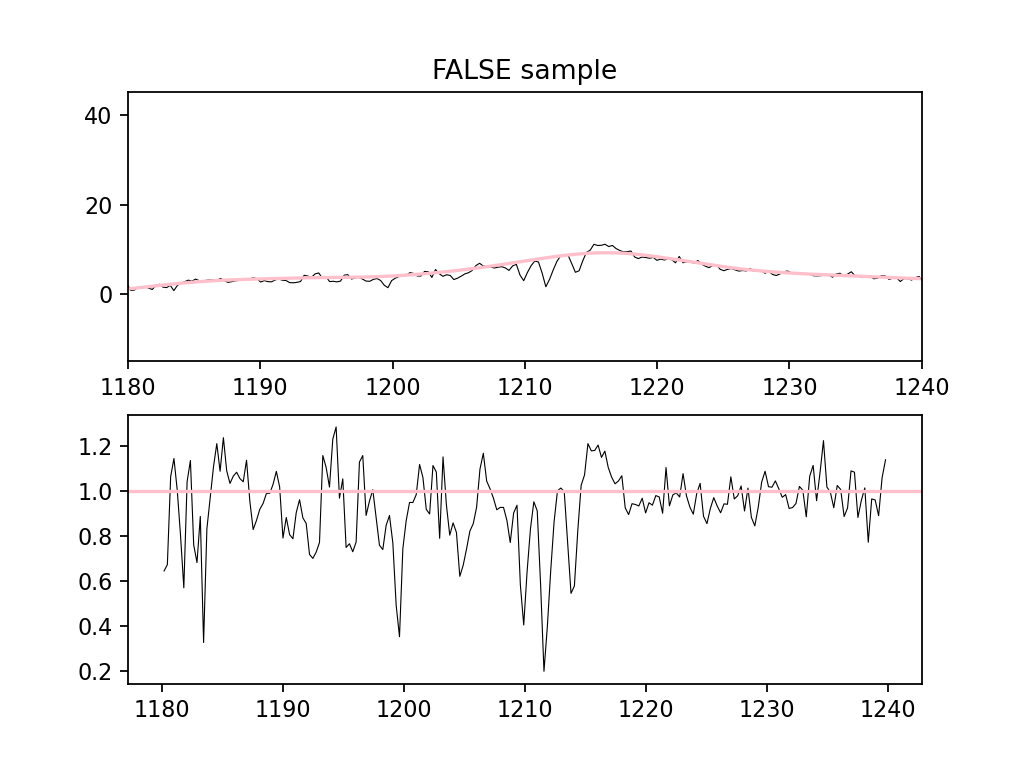

<IPython.core.display.Javascript object>


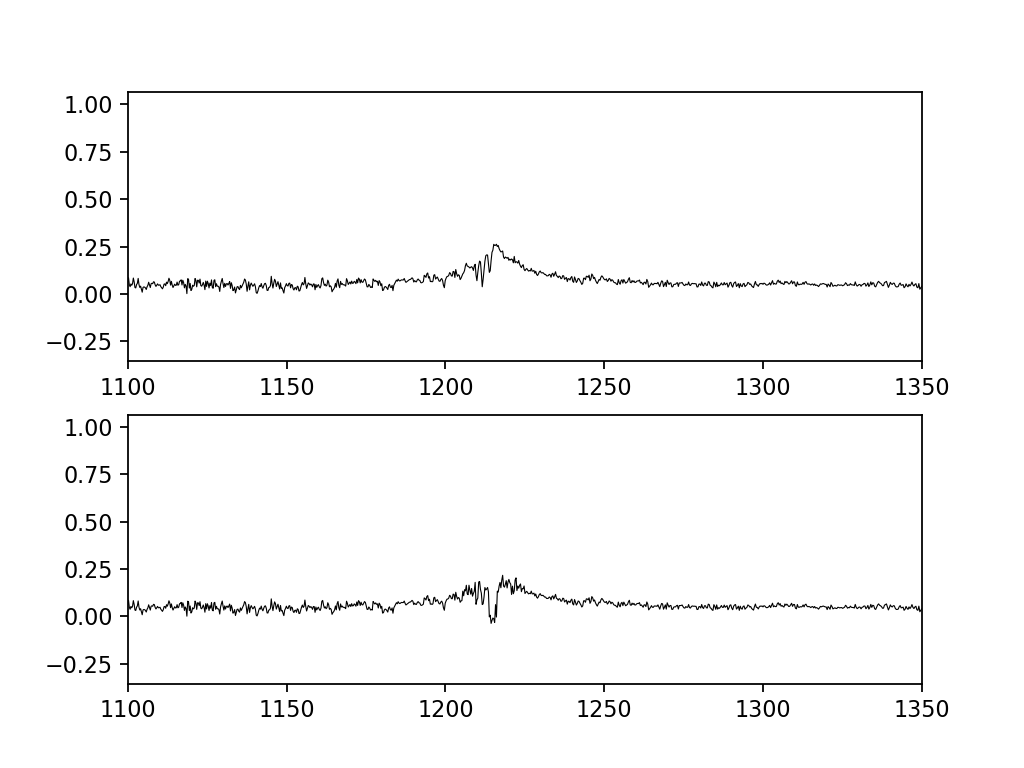

<IPython.core.display.Javascript object>


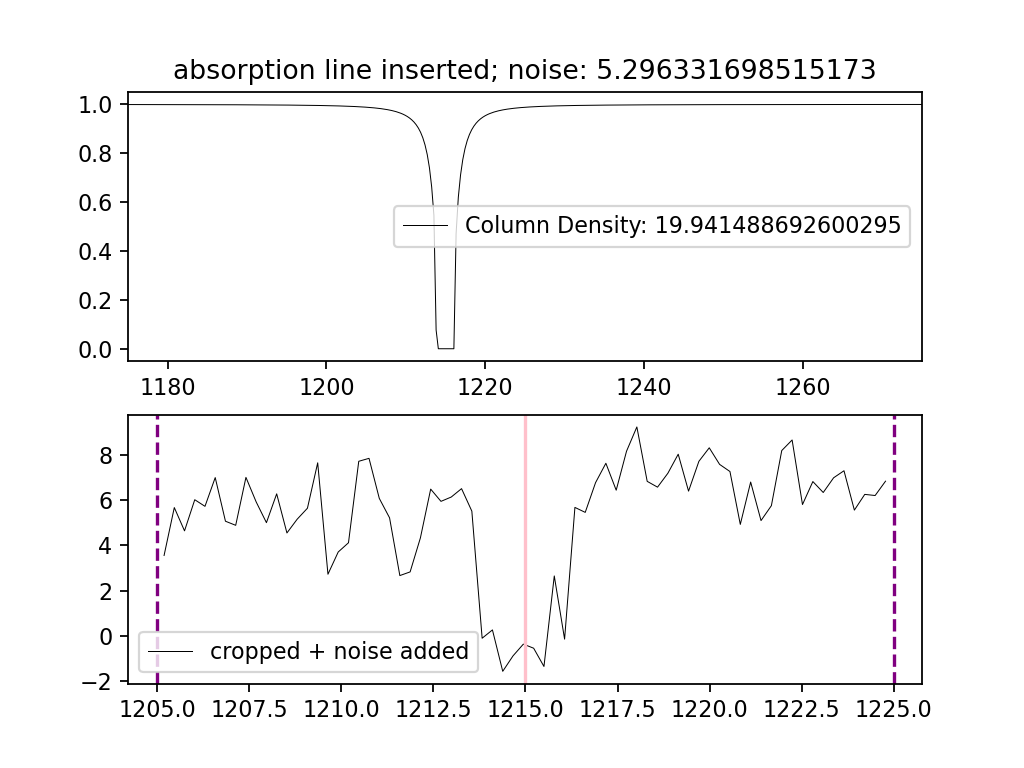

<IPython.core.display.Javascript object>


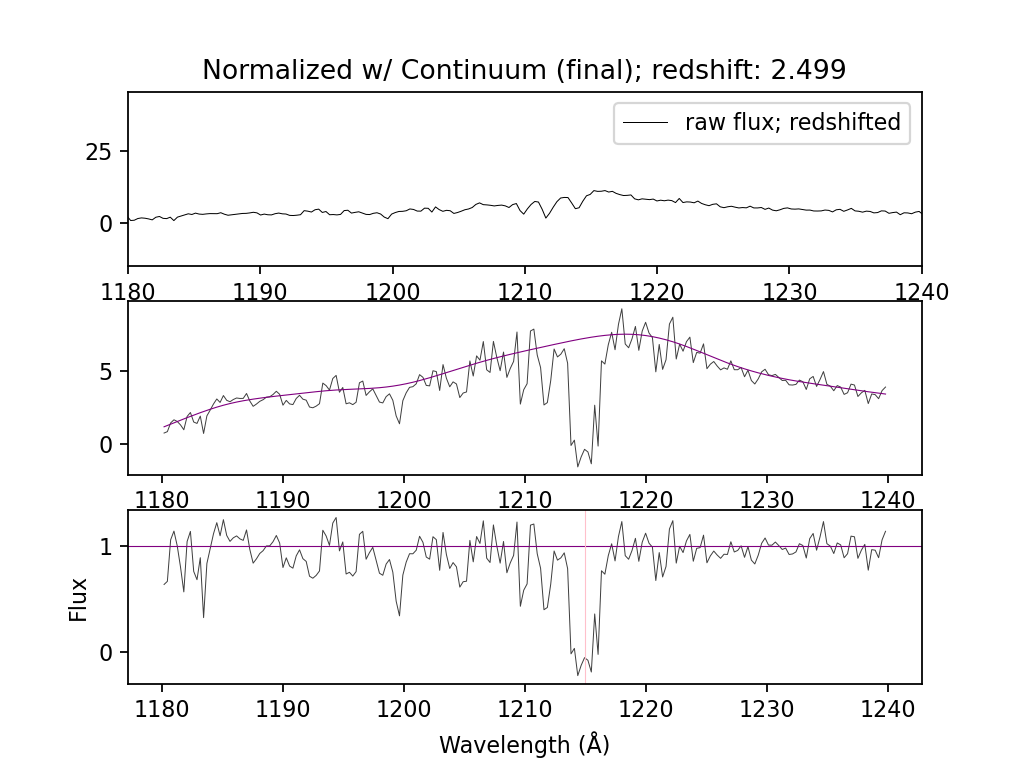

In [5]:
pos, neg = insert_absorption_line(0, True);

<IPython.core.display.Javascript object>


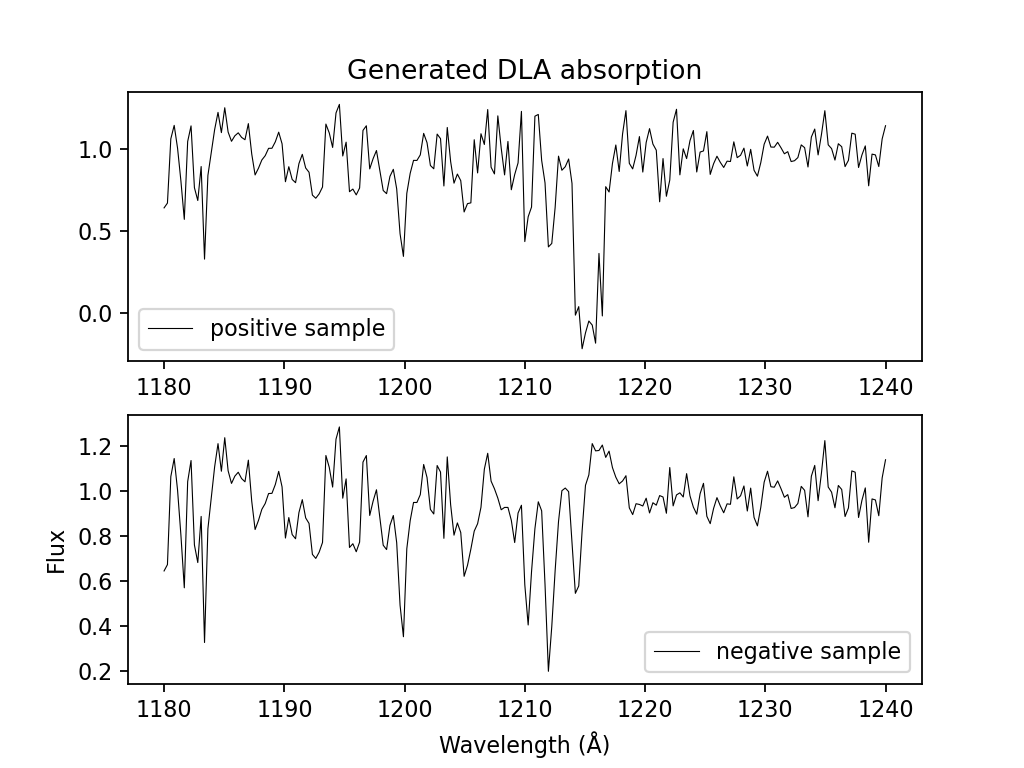

In [6]:
fig, (ax1, ax2) = plt.subplots(2)
wl = np.linspace(1180, 1240, 215)
ax1.set_title("Generated DLA absorption")
ax1.plot(wl, pos, color = "black", linewidth = 0.5, label = "positive sample")
ax1.legend()
plt.ylabel("Flux")
plt.xlabel("Wavelength (Å)")
ax2.plot(wl, neg, color = "black", linewidth = 0.5, label = "negative sample")
ax2.legend()

In [35]:
n = 10

import warnings
warnings.filterwarnings("ignore")

positive_sample = np.zeros((n, 215), dtype = np.float32) ### Each sample is 101 data points wide (according to the +-50 from above)
negative_sample = np.zeros((n, 215), dtype = np.float32)

from tqdm.notebook import tqdm
samp_num = 0
for i in tqdm(range(n)):
    
    while True:
        try:
            positive_sample[i, :], negative_sample[i, :] = insert_absorption_line(samp_num, False)
            break
        except:
            samp_num += 1
    samp_num += 1

  0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


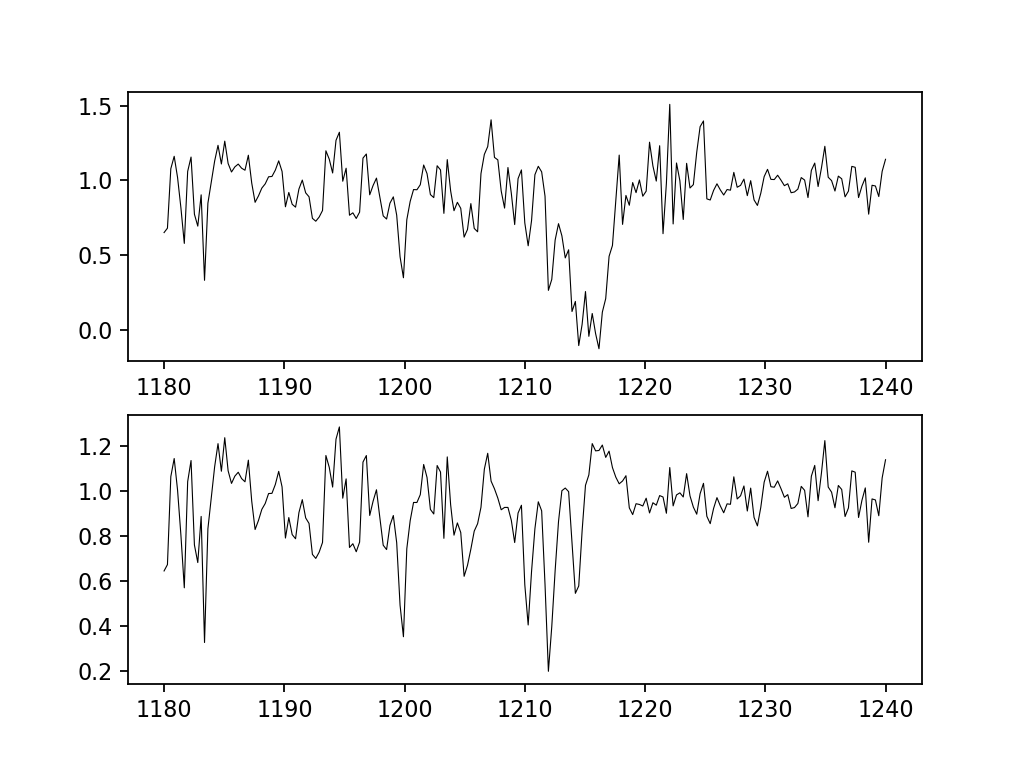

In [36]:
wl = np.linspace(1180, 1240, 215)
for i in range(1):
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(wl, positive_sample[i, :], linewidth = 0.5, color = "black")
    ax2.plot(wl, negative_sample[i, :], linewidth = 0.5, color = "black")